# Customer shopping

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from typing import List

%matplotlib inline
plt.style.use('ggplot')

## Funciones utiles

### Gráficas

In [2]:
def pie_plot(data: pd.DataFrame, col: str) -> None:
    """Genera un gráfico de torta basado en una columna de un DataFrame.

    Args:
        data (pd.DataFrame): El DataFrame que contiene los datos.
        col (str): El nombre de la columna a graficar.

    Returns:
        None: Muestra el gráfico de pastel.

    """
    plt.figure(figsize=(8, 5))
    datos = data[col]
    labels = data.index
    
    # Se agregan colores con plt.cm estableciendo un color para cada espacio en el 
    # diagrama, por eso se usa un linspace de la misma magnitud de los datos.
    colors = plt.cm.RdYlGn(np.linspace(0.1, 0.7, len(datos)))
    
    # Generación del diagrama circular
    patches, texts = plt.pie(datos, labels=labels, colors=colors)

    # Para que siempre se vea como un círculo
    plt.axis('equal')
    
    # Se eliminan las líneas
    plt.rcParams['patch.linewidth'] = 0
    
    # Estimación porcentaje
    porcent = 100 * datos / sum(datos)
    # Lista que será expuesta en la legenda
    labels = ['{0} - {1:1.1f} %'.format(i,j) for i, j in zip(labels, porcent)]
    
    # Se genera la legenda
    # bbox_to_anchor especifica en coordenadas la posición de la legenda
    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
    
    plt.show()

In [3]:
def box_plot(df: pd.DataFrame, showfliers: bool = True):
    """Genera un diagrama de cajas utilizando el mapa de colores RdYlGn.

    Args:
        df (pd.DataFrame): El DataFrame que se utilizará para generar 
         el diagrama de cajas.
        showfliers (bool): Indica si se muestran o no los valores 
         atípicos en el diagrama de cajas. Valor predeterminado es True.

    Returns:
        None: Muestra el gráfico de barras.
        
    """
    # Generar el diagrama de cajas utilizando df.plot(kind='box')
    ax = df.plot(kind='box', patch_artist=True, figsize=(8, 5), showfliers=showfliers, vert=False)
    
    # Configurar el mapa de colores
    cmap = plt.cm.RdYlGn
    
    # Personalizar el color de las cajas utilizando el mapa de colores
    for patch, color in zip(ax.artists, cmap(np.linspace(0.1, 0.9, len(ax.artists)))):
        patch.set_facecolor(color)

    plt.show()

In [4]:
def bar_subplots(df: pd.DataFrame, 
                 columnas: List[str],
                 savefig: bool = False) -> None:
    """
    Genera diagramas de barras para contar la cantidad 
     de hurtos en cada columna especificada.

    Args:
        df: DataFrame que contiene los datos de los hurtos.
        columnas: Lista de columnas del DataFrame a 
         mostrar en los diagramas de barras.
        savefig: Opcional. Si se quiere guardar la imagen 
         en output.

    """
    num_columnas = len(columnas)
    num_filas = num_columnas // 2 + num_columnas % 2 

    fig, axs = plt.subplots(num_filas, 2, figsize=(12, 4 * num_filas))
    fig.tight_layout(pad=4.0)

    for i, columna in enumerate(columnas):
        ax = axs[i // 2, i % 2] if num_filas > 1 else axs[i]
        valores = df[columna].value_counts()

        ax.bar(valores.index, valores.values)
        ax.set_title(f"Transacciones {columna}")
        plt.xlabel(None)
        ax.yaxis.set_visible(False)
        
        ax.set_xticks(range(len(valores.index))) 
        ax.set_xticklabels(valores.index, rotation=20) 

        for p in ax.patches:
            ax.annotate(
                '{:,.0f}'.format(int(p.get_height())).replace(",", "."),
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=10)

        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
    
    if savefig:
        plt.savefig(Path('..') / 'output' / 'fig.png', bbox_inches='tight')
    plt.show()

### Limpieza

In [5]:
def find_missing(df: pd.DataFrame) -> pd.DataFrame:
    """Encuentra los valores faltantes en un DataFrame y devuelve un nuevo DataFrame
     que muestra la cantidad de valores faltantes y el porcentaje correspondiente.

    Args:
        df (pd.DataFrame): El DataFrame que se va a analizar.

    Returns:
        pd.DataFrame: Un nuevo DataFrame que muestra las columnas, la cantidad de
        valores faltantes y el porcentaje de valores faltantes para cada columna.

    """
    lista = []
    for col in df.columns:
        num = df[df[col].isnull()].shape[0]
        lista.append(num)
    
    dic = {
        'Columnas': df.columns,
        'Faltantes': lista}
    df_faltantes = pd.DataFrame(dic)
    
    df_faltantes['Porcentaje'] = df_faltantes['Faltantes'] / df.shape[0]
    
    return df_faltantes

# Exploración de datos

## Carga de datos

In [6]:
path = os.path.join('..', 'data', 'customer_shopping_data.csv')
shopping_data = pd.read_csv(path)

In [7]:
shopping_data.head(2)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul


In [8]:
shopping_data.shape

(99457, 10)

In [9]:
shopping_data['shopping_mall'].value_counts()

Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: shopping_mall, dtype: int64

In [10]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


## Visualización características

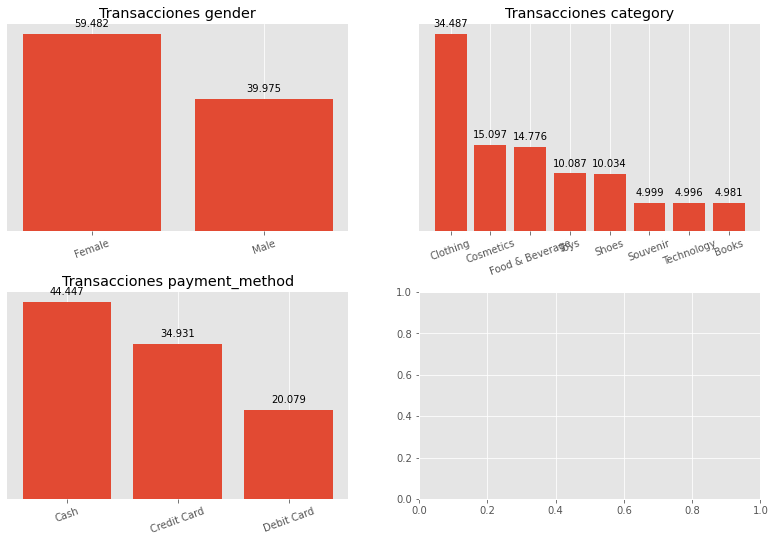

In [11]:
cols = ['gender', 'category', 'payment_method']

bar_subplots(shopping_data, cols, savefig=False)

In [12]:
gender = shopping_data.groupby('gender').agg({'customer_id': 'count'})

In [13]:
gender

,customer_id
gender,
Female,59482
Male,39975


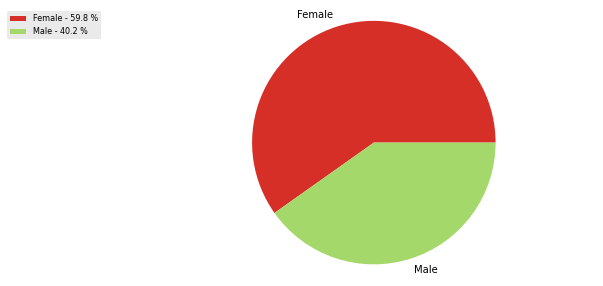

In [14]:
pie_plot(gender, 'customer_id')

* En la gráfica anterior se evidencia que son las mujeres las que tienen una mayor participación en las compras con una diferencia de $19.507$ transacciones de diferencia.

In [15]:
payment_method = shopping_data.groupby('payment_method').agg({'customer_id': 'count'})

In [16]:
payment_method

,customer_id
payment_method,
Cash,44447
Credit Card,34931
Debit Card,20079


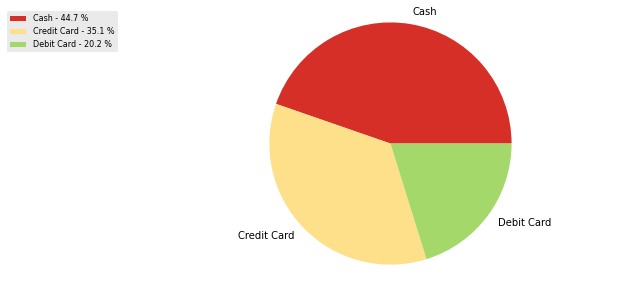

In [17]:
pie_plot(payment_method, 'customer_id')

* La mayoría de las compras registradas en el data set se realizan con efectivo, teniendo una participación del 44.75%, seguido de las tarjetas crédito y débito con 35.1% y 20.2% respectivamente.

## Imputación de datos

In [18]:
missing_values = find_missing(shopping_data)

In [19]:
missing_values

,Columnas,Faltantes,Porcentaje
0,invoice_no,0,0.0
1,customer_id,0,0.0
2,gender,0,0.0
3,age,0,0.0
4,category,0,0.0
5,quantity,0,0.0
6,price,0,0.0
7,payment_method,0,0.0
8,invoice_date,0,0.0
9,shopping_mall,0,0.0


## Datos atípicos

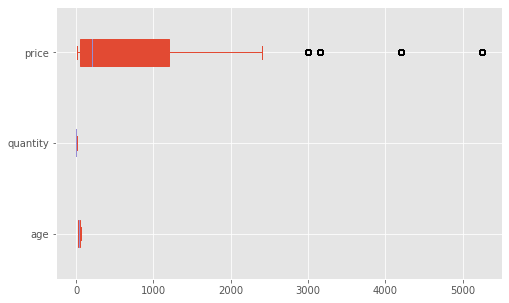

In [20]:
box_plot(shopping_data)

* Se seleccionan las columnas numéricas para escalar y tener un diagrama de cajas con las caracteríscas en la misma escala

In [21]:
columns_numeric = shopping_data.select_dtypes(include=['float64', 'int64'])

In [22]:
columns_numeric

,age,quantity,price
0,28,5,1500.40
1,21,3,1800.51
2,20,1,300.08
3,66,5,3000.85
4,53,4,60.60
...,...,...,...
99452,45,5,58.65
99453,27,2,10.46
99454,63,2,10.46
99455,56,4,4200.00


In [23]:
# Normalización de los datos

min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(columns_numeric)

numeric_scale = pd.DataFrame(numeric_scale, columns=columns_numeric.columns)

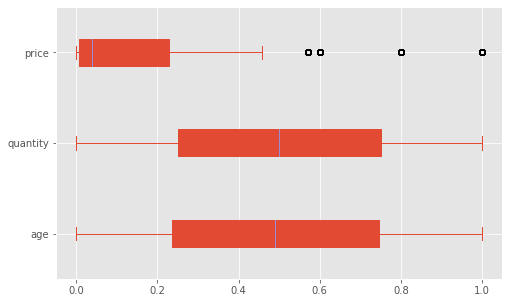

In [24]:
box_plot(numeric_scale)

## Detección de outliers con el algoritmo LOF

In [25]:
lof = LocalOutlierFactor(
    n_neighbors=5, 
    algorithm='auto', 
    contamination='auto', 
    metric='euclidean')

In [26]:
lof_array = lof.fit_predict(numeric_scale)

In [27]:
ground_truth = np.ones(len(numeric_scale), dtype=int)

In [28]:
n_errors = (lof_array != ground_truth).sum()

In [29]:
n_errors

0

Bajo el algoritmo LOF no se encontraron datos atípicos por lo que no hay necesidad de realizar imputación de datos.

# Transformaciones

Se realizará una revisión acerca de la distribución de la categorias que están en la columna payment_method

In [30]:
shopping_data['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: category, dtype: int64

In [31]:
categories_shopping = shopping_data.groupby('category').agg({'customer_id': 'count'})

In [32]:
categories_shopping

,customer_id
category,
Books,4981
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Shoes,10034
Souvenir,4999
Technology,4996
Toys,10087


In [33]:
categories_shopping['per'] = categories_shopping['customer_id'] / categories_shopping['customer_id'].sum() * 100

In [34]:
categories_shopping = categories_shopping.sort_values(by='customer_id', ascending=False)

In [35]:
categories_shopping

,customer_id,per
category,,
Clothing,34487,34.675287
Cosmetics,15097,15.179424
Food & Beverage,14776,14.856672
Toys,10087,10.142071
Shoes,10034,10.088782
Souvenir,4999,5.026293
Technology,4996,5.023276
Books,4981,5.008194


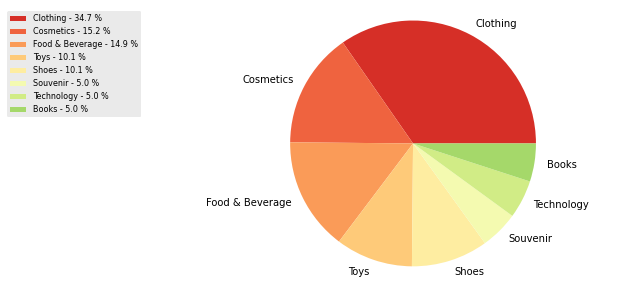

In [36]:
pie_plot(categories_shopping, 'customer_id')

## Agrupación de categorias de bajo porcentaje de participación

* Eliminar la columna Technology porque no aporta suficientes datos al modelo.

In [37]:
cond = shopping_data['category'] != 'Technology'
shopping_data = shopping_data[cond]

In [38]:
cats = ['Souvenir', 'Books']

for cat in cats:
    cond = shopping_data['category'] == cat
    shopping_data.loc[cond, 'category'] = 'Other'

In [39]:
categories_shopping = shopping_data.groupby('category').agg({'customer_id': 'count'})

In [40]:
categories_shopping

,customer_id
category,
Clothing,34487
Cosmetics,15097
Food & Beverage,14776
Other,9980
Shoes,10034
Toys,10087


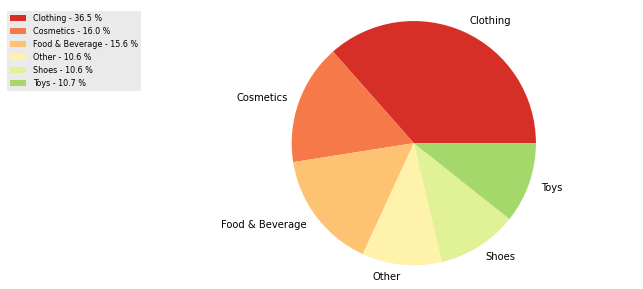

In [41]:
pie_plot(categories_shopping, 'customer_id')

## Creación de nuevas columnas

In [42]:
shopping_data.columns

Index(['invoice_no', 'customer_id', 'gender', 'age', 'category', 'quantity',
       'price', 'payment_method', 'invoice_date', 'shopping_mall'],
      dtype='object')

In [43]:
columns = ['gender', 'age', 'category', 'quantity', 'price', 'payment_method']

In [44]:
data_set = shopping_data[columns]

Se aplicara el metodo get dummies para de esta forma ampliar el data set y tener un mayor número de columnas

In [45]:
data_set = pd.get_dummies(data_set, columns=['gender', 'payment_method'])

In [46]:
data_set.head()

,age,category,quantity,price,gender_Female,gender_Male,payment_method_Cash,payment_method_Credit Card,payment_method_Debit Card
0,28,Clothing,5,1500.40,1,0,0,1,0
1,21,Shoes,3,1800.51,0,1,0,0,1
2,20,Clothing,1,300.08,0,1,1,0,0
3,66,Shoes,5,3000.85,1,0,0,1,0
4,53,Other,4,60.60,1,0,1,0,0


In [47]:
path_save = os.path.join('..', 'data', 'customers_model.csv')
data_set.to_csv(path_save, index=False)